# Gridded Datasets

In [1]:
import xarray as xr
import numpy as np
import holoviews as hv
hv.extension('matplotlib')
%opts Scatter3D [size_index=None color_index=3] (cmap='fire')

In the [Tabular Data](./07-Tabular_Datasets.ipynb) guide we covered how to work with columnar data in HoloViews. Apart from tabular or column based data there is another data format that is particularly common in the science and engineering contexts, namely multi-dimensional arrays. The gridded data interfaces allow working with grid-based datasets directly.

Grid-based datasets have two types of dimensions:

* they have coordinate or key dimensions, which describe the sampling of each dimension in the value arrays
* they have value dimensions which describe the quantity of the multi-dimensional value arrays


## Declaring gridded data

All Elements that support a ColumnInterface also support the GridInterface. The simplest example of a multi-dimensional (or more precisely 2D) gridded dataset is an image, which has implicit or explicit x-coordinates, y-coordinates and an array representing the values for each combination of these coordinates. Let us start by declaring an Image with explicit x- and y-coordinates:

In [ ]:
img = hv.Image((range(10), range(5), np.random.rand(5, 10)), datatype=['grid'])
img

In the above example we defined that there would be 10 samples along the x-axis, 5 samples along the y-axis and then defined a random ``5x10`` array, matching those dimensions. This follows the NumPy (row, column) indexing convention. When passing a tuple HoloViews will use the first gridded data interface, which stores the coordinates and value arrays as a dictionary mapping the dimension name to a NumPy array representing the data:

In [ ]:
img.data

However HoloViews also ships with interfaces for ``xarray`` and ``iris``, two common libraries for working with multi-dimensional datasets:

In [ ]:
xr_img = img.clone(datatype=['xarray'])
arr_img = img.clone(datatype=['image'])
iris_img = img.clone(datatype=['cube'])

print(type(xr_img.data))
print(type(iris_img.data))
print(type(arr_img.data))

In the case of an Image HoloViews also has a simple image representation which stores the data as a single array and converts the x- and y-coordinates to a set of bounds:

In [ ]:
print("Array type: %s with bounds %s" % (type(arr_img.data), arr_img.bounds))

To summarize the constructor accepts a number of formats where the value arrays should always match the shape of the coordinate arrays:

    1. A simple np.ndarray along with (l, b, r, t) bounds
    2. A tuple of the coordinate and value arrays
    3. A dictionary of the coordinate and value arrays indexed by their dimension names
    3. XArray DataArray or XArray Dataset
    4. An Iris cube

# Working with a multi-dimensional dataset

A gridded Dataset may have as many dimensions as desired, however individual Element types only support data of a certain dimensionality. Therefore we usually declare a ``Dataset`` to hold our multi-dimensional data and take it from there.

In [ ]:
dataset3d = hv.Dataset((range(3), range(5), range(7), np.random.randn(7, 5, 3)),
                       ['x', 'y', 'z'], 'Value')
dataset3d

This is because even a 3D multi-dimensional array represents volumetric data which we can display easily only if it contains few samples. In this simple case we can get an overview of what this data looks like by casting it to a ``Scatter3D`` Element (which will help us visualize the operations we are applying to the data:

In [ ]:
hv.Scatter3D(dataset3d)

### Indexing

In order to explore the dataset we therefore often want to define a lower dimensional slice into the array and then convert the dataset:

In [ ]:
dataset3d.select(x=1).to(hv.Image, ['y', 'z']) + hv.Scatter3D(dataset3d.select(x=1))

### Groupby

Another common method to apply to our data is to facet or animate the data using ``groupby`` operations. HoloViews provides a convient interface to apply ``groupby`` operations and select which dimensions to visualize. 

In [ ]:
(dataset3d.to(hv.Image, ['y', 'z'], 'Value', ['x']) +
hv.HoloMap({x: hv.Scatter3D(dataset3d.select(x=x)) for x in range(3)}, kdims='x'))

### Aggregating

Another common operation is to aggregate the data with a function thereby reducing a dimension. You can either ``aggregate`` the data by passing the dimensions to aggregate or ``reduce`` a specific dimension. Both have the same function:

In [ ]:
hv.Image(dataset3d.aggregate(['x', 'y'], np.mean)) + hv.Image(dataset3d.reduce(z=np.mean))

By aggregating the data we can reduce it to any number of dimensions we want. We can for example compute the spread of values for each z-coordinate and plot it using a ``Spread`` and ``Curve`` Element. We simply aggregate by that dimension and pass the aggregation functions we want to apply:

In [ ]:
hv.Spread(dataset3d.aggregate('z', np.mean, np.std)) * hv.Curve(dataset3d.aggregate('z', np.mean))

It is also possible to generate lower-dimensional views into the dataset which can be useful to summarize the statistics of the data along a particular dimension. A simple example is a box-whisker of the ``Value`` for each x-coordinate. Using the ``.to`` conversion interface we declare that we want a ``BoxWhisker`` Element indexed by the ``x`` dimension showing the ``Value`` dimension. Additionally we have to ensure to set ``groupby`` to an empty list because by default the interface will group over any remaining dimension.

In [ ]:
dataset3d.to(hv.BoxWhisker, 'x', 'Value', groupby=[])

Similarly we can generate a ``Distribution`` Element showing the ``Value`` dimension, group by the 'x' dimension and then overlay the distributions, giving us another statistical summary of the data:

In [ ]:
dataset3d.to(hv.Distribution, 'Value', [], groupby='x').overlay()

## Categorical dimensions

The key dimensions of the multi-dimensional arrays do not have to represent continuous values, we can display datasets with categorical variables as a ``HeatMap`` Element:

In [ ]:
heatmap = hv.HeatMap((['A', 'B', 'C'], ['a', 'b', 'c', 'd', 'e'], np.random.rand(5, 3)))
heatmap + heatmap.table()

## Working with xarray data types
As demonstrated previously, `Dataset` comes with support for the `xarray` library, which offers a powerful way to work with multi-dimensional, regularly spaced data. In this example, we'll load an example dataset, turn it into a HoloViews `Dataset` and visualize it. First, let's have a look at the xarray dataset's contents:

In [20]:
xr_ds = xr.tutorial.load_dataset("air_temperature")
xr_ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 62.5 60.0 57.5 55.0 52.5 ...
  * lon      (lon) float32 200.0 202.5 205.0 207.5 210.0 212.5 215.0 217.5 ...
  * time     (time) datetime64[ns] 2013-01-01 2013-01-01T06:00:00 ...
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 244.0 244.09999 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

It is trivial to turn this xarray Dataset into a Holoviews `Dataset` (the same also works for DataArray):

In [30]:
hv_ds = hv.Dataset(xr_ds)[:, :, "2013-01-01"]
print(hv_ds)

:Dataset   [lat,lon,time]   (air)


We have used the usual slice notation in order to select one single day in the rather large dataset. Finally, let's visualize the dataset by converting it to a `HoloMap` of `Images` using the `to()` method. We need to specify which of the dataset's key dimensions will be consumed by the images (in this case "lat" and "lon"), where the remaing key dimensions will be associated with the HoloMap (here: "time"). We'll use the slice notation again to clip the longitude.

:HoloMap   [time]
   :Image   [lon,lat]   (air)
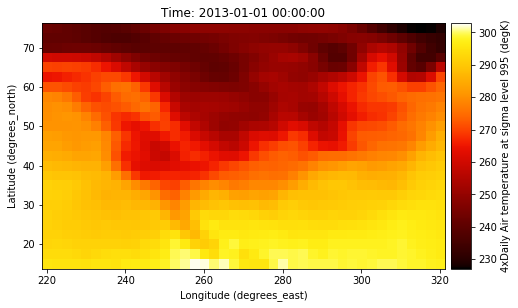
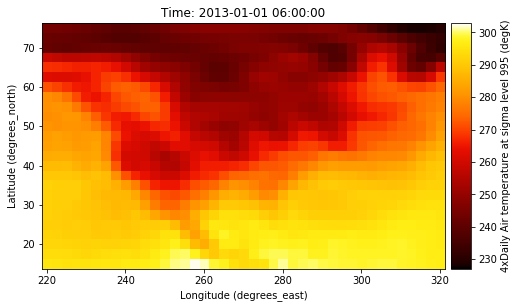
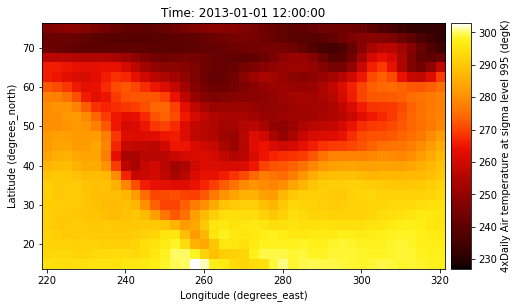
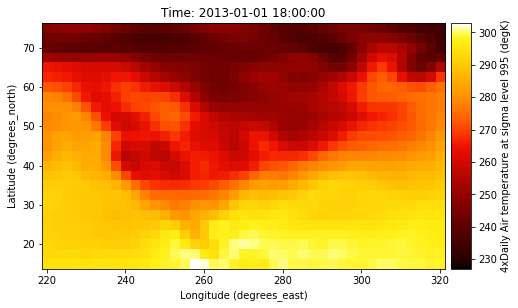

In [31]:
%%opts Image [colorbar=True]
%%output size=200
hv_ds.to(hv.Image, kdims=["lon", "lat"])[:, 220:320, :]

Note, that this approach immediately converts all available data to images, which will take up a lot of RAM for large datasets. For these situations, consider using a [DynamicMap](./06-Live_Data.ipynb) in conjunction with [xarray's dask support](http://xarray.pydata.org/en/stable/dask.html) instead.

Additional examples of visualizing xarrays in the context of geographical data can be found in the GeoViews documentation: [Gridded Datasets I](http://geo.holoviews.org/Gridded_Datasets_I.html) and
[Gridded Datasets II](http://geo.holoviews.org/Gridded_Datasets_II.html). These guides also contain useful information on the interaction between xarray data structures and HoloViews Datasets in general.

# API

## Accessing the data

In order to be able to work with data in different formats Holoviews defines a general interface to access the data. The dimension_values method allows returning underlying arrays.

#### Key dimensions (coordinates)

By default ``dimension_values`` will return the expanded columnar format of the data:

In [ ]:
heatmap.dimension_values('x')

To access just the unique coordinates along a dimension simply supply the ``expanded=False`` keyword:

In [ ]:
heatmap.dimension_values('x', expanded=False)

Finally we can also get a non-flattened, expanded coordinate array returning a coordinate array of the same shape as the value arrays

In [ ]:
heatmap.dimension_values('x', flat=False)

#### Value dimensions

When accessing a value dimension the method will similarly return a flat view of the data:

In [ ]:
heatmap.dimension_values('z')

We can pass the ``flat=False`` argument to access the multi-dimensional array:

In [ ]:
heatmap.dimension_values('z', flat=False)